# Setup

In [176]:
import numpy as np
import pandas as pd
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import scipy
from scipy.stats import boxcox
from scipy.special import boxcox1p
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LassoCV
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from IPython.display import display

warnings.filterwarnings("ignore")

## Import Data

In [145]:
data = pd.read_csv("Data/data_clean.csv", index_col = [0])

data.loc[(data['age'] > 14) & (data['age'] <= 24), 'Age_Group'] = 1 #'Youth (15-24)'
data.loc[(data['age'] > 25) & (data['age'] <= 64), 'Age_Group'] = 2 #'Adults (25-64)'
data.loc[(data['age'] >= 65), 'Age_Group'] = 3 # 'Seniors (65+)'

# Find NAs and fix
data = data.dropna()
data['Age_Group'] = data['Age_Group'].astype('int')

data.head()

,score,Influence,Modesty,Daring,Confidence,Ruling,Responsibility,IntrovExtro,Success,Humble,...,MakeBelieve,Leadership Origin,Biography,Public Opinion,Capability,Extraordinary,elapse,gender,age,Age_Group
0,18,2,2,2,2,1,2,1,2,2,...,1,2,2,2,1,2,211,1,50,2
1,6,2,2,2,1,2,2,1,2,1,...,1,2,2,2,2,1,149,1,40,2
2,27,1,2,2,1,2,1,2,1,2,...,2,1,1,2,1,2,168,1,28,2
3,29,1,1,2,2,2,1,2,1,1,...,2,1,2,2,1,1,230,1,37,2
4,6,1,2,1,1,1,2,1,2,1,...,1,2,2,2,0,1,389,1,50,2


## Visualizing the data

In [146]:
px.histogram(data, x="score", color="gender", marginal="rug",)

In [147]:
px.box(data,x="score", y="age", notched=True,
       color_discrete_sequence=px.colors.qualitative.Bold,
       title="Score Against Age")

In [148]:
display(px.box(data, x = 'Age_Group', y = 'score', color = 'gender', title="Score Against Age Group"))

We can see from the above plots that the narcissitic trait tends to decline with age.

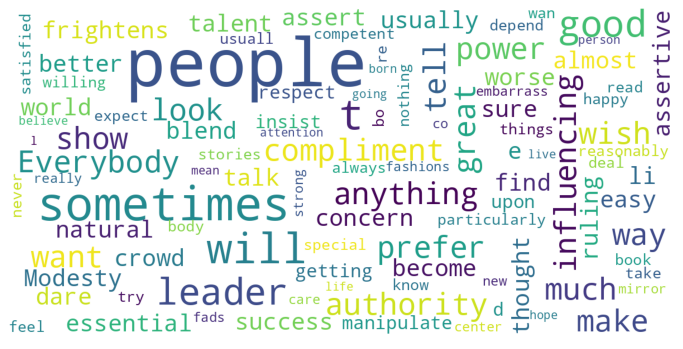

In [149]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=100,
        max_font_size=40,
        scale=3,
        random_state=1,  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)

show_wordcloud(pd.read_csv("Data/codebookCleaned.txt"))

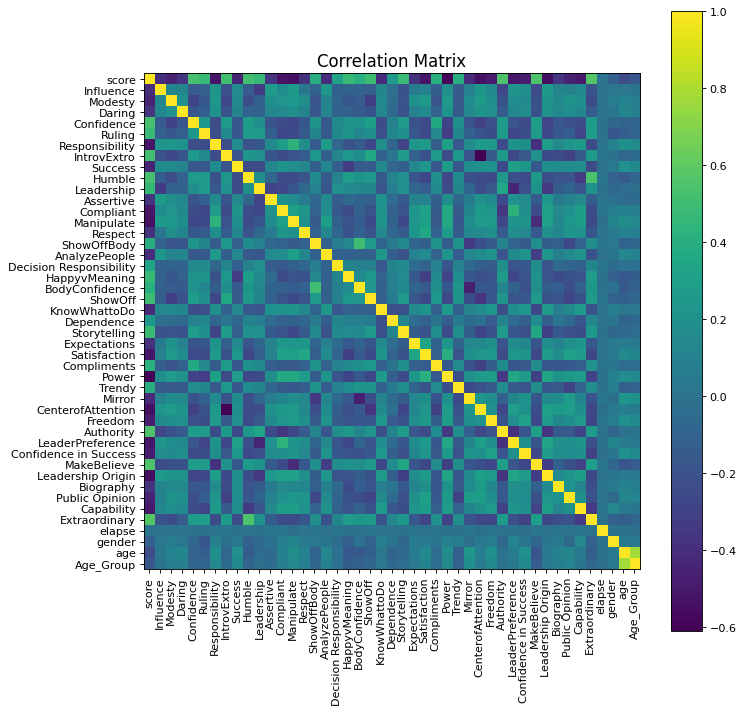

In [150]:
# Correlation matrix

def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
    
plotCorrelationMatrix(data, 10)

## ANOVA

### Checking Assumptions for ANOVA

If one of the assumptions of normality or equal variance is violated, we cannot perform the Two Factor ANOVA test for our data analysis. The next steps would be to re-evaluate the dataset and examine any missed outliers skewing our data excessively and/or any data transformations.

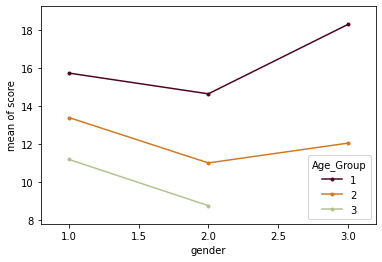

In [151]:
# Make an interaction plot
fig = interaction_plot(x=data['gender'], trace=data['Age_Group'], response=data['score'], 
    colors=['#4c061d','#d17a22', '#b4c292'])

#### Normality Assumption

Since none of the lines touch each other, there is no sign of an interaction effect between gender and age group.

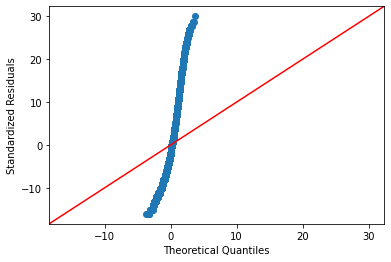

In [152]:
model = ols('score ~ C(Age_Group) + C(gender)', data=data).fit()
sm.qqplot(model.resid, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

The points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data violates the normality assumption.

### Box Cox Transformation (Method #1)

We will try performing a BoxCox transformation of the non-normal dependent variable (score) in an effort to improve the data's compliance to the normality assumption.

In [153]:
#transformed_data, best_lambda = boxcox(data['score'])

The above error is a result of the parameter restriction for x, which has to be a positive 1-dimensional input array. Since the `score` column (dependent variable) contains 0s, we cannot use scipy.stats.boxcox. However, there is a workaround using scipy.special.boxcox1p, which works on an x input array containing 0s (does the calculation 1+x). A disadvantage is that in addition to the data (input array), one of its input parameters requires lambda. Since we do not know the optimal lambda value, we would have to trial-and-error different lambda values for our data's compliance with the normality assumption.

In [154]:
transformed_data = scipy.special.boxcox1p(data['score'], 0.6)
data.insert(1,'score_bc', transformed_data)
data[['score', 'score_bc']]

,score,score_bc
0,18,8.085495
1,6,3.690160
2,27,10.640089
3,29,11.160227
4,6,3.690160
...,...,...
11238,1,0.859528
11239,10,5.358949
11240,6,3.690160
11241,12,6.099644


Now that we have transformed the data, let us recheck the normality assumption.

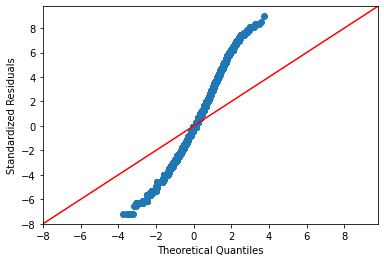

In [155]:
model = ols('score_bc ~ C(Age_Group) + C(gender)', data=data).fit()
sm.qqplot(model.resid, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

While using scipy.stats.boxcox slightly improved our data's compliance to the normality assumption, it barely holds. This could be due to many reasons, one being that we did not choose the optimal lambda value for the BoxCox transformation. To resolve this doubt, we can use the PowerTransformer from sklearn.preprocessing to find the optimal lambda value, as well as transform our data accordingly.

### BoxCox Transformation (Method #2)

In [156]:
pt = PowerTransformer(method='yeo-johnson')
score_df = pd.DataFrame(data['score'])
pt.fit(score_df)
print(pt.lambdas_) # optimal lambda value

[0.36451784]


The above output is the optimal lambda value for the Box Cox transformation of our data. We will use it to transform the `score` column and update our model.

In [157]:
transformed_data = pt.transform(score_df)
data.insert(2,'score_bc2', transformed_data)
data[['score', 'score_bc', 'score_bc2']]

,score,score_bc,score_bc2
0,18,8.085495,0.689621
1,6,3.690160,-0.824962
2,27,10.640089,1.443323
3,29,11.160227,1.588949
4,6,3.690160,-0.824962
...,...,...,...
11238,1,0.859528,-2.089625
11239,10,5.358949,-0.207099
11240,6,3.690160,-0.824962
11241,12,6.099644,0.048289


Now that we have transformed the data again, let us recheck the normality assumption.

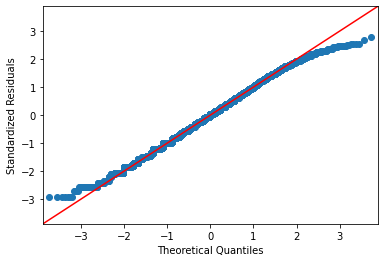

In [158]:
model3 = ols('score_bc2 ~ C(Age_Group) + C(gender)', data=data).fit()
sm.qqplot(model3.resid, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

In general, the points seem to fall into a relatively tight, straight line on the plot. Points at both ends of the y=x line deviate slightly; however, they are not significant enough to put the normality assumption into question.

#### Shapiro-Wilk's Test
We will also perform a Shapiro-Wilk's test to quantify the ability to accept/reject the normality assumption.

In [159]:
w, pvalue = stats.shapiro(model3.resid)
print(w, pvalue)

0.9971815347671509 2.1798558238420723e-13


/home/thedarceye/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



Since the p-value of 1.816347094431292e-13 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is stiatistically significant evidence to suggest that the normality assumption does not hold. While this contradicts our findings from the residuals plot, we can also use a histogram to visualize that the residuals are approximately normally distributed.

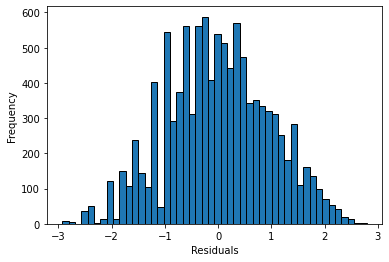

In [160]:
plt.hist(model3.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

Thus, we will assume that the normality assumption holds. (lmfao)

#### Homoscedasticity

***Explanation Here***

#### Levene's Test

***Explanation Here***

#### Multiple Pairwise Comparisons (Post-Hoc)

***Explanation Here***

Now that we have checked the ANOVA assumptions, we may now proceed with the Two-Factor ANOVA Test.

### Two-Factor ANOVA Test

#### Model Summary

In [161]:
display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              score_bc2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     133.3
Date:                Sat, 30 Apr 2022   Prob (F-statistic):          2.63e-111
Time:                        18:43:34   Log-Likelihood:                -14944.
No. Observations:               10715   AIC:                         2.990e+04
Df Residuals:                   10710   BIC:                         2.993e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3488      0.018     19.076      0.000       0.313       0.385
C(Age_Group)[T.2]    -0.3603      0.020    -17.741      0.000      -0.400      -0.321
C(Age_Group)[T.3]    -0.6733      0.060    -11.239      0.000      -0.791      -0.556
C(gender)[T.2]       -0.2275      0.019    -11.903      0.000      -0.265      -0.190
C(gender)[T.3]        0.0835      0.161      0.519      0.604      -0.232       0.399
==============================================================================
Omnibus:                       74.281   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.638
Skew:                          -0.029   Prob(JB):                     6.12e-12
Kurtosis:                       2.665   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Explanation Here***

#### ANOVA Test

In [162]:
anova_table = sm.stats.anova_lm(model3, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Age_Group),352.138763,2.0,184.748306,1.311779e-79
C(gender),136.221747,2.0,71.468238,1.469039e-31
Residual,10206.876120,10710.0,NaN,NaN


#### Kruskal-Wallis H-test 

***Explanation Here***

In [165]:
stats.kruskal(data['gender'], data['Age_Group'], data['score_bc2'])

KruskalResult(statistic=16552.555718937045, pvalue=0.0)

We can see from the results of the Kruskal-Wallis H-test that there is a statistically significant difference between the medians of the three age groups.

## LASSO Regression

Least Absolute Shrinkage Operator 

(Blurb about LASSO)

In [175]:
# Create dummy variables for gender
dummies = pd.get_dummies(data["gender"])
dummies = dummies.rename(columns={1: "Male", 2: "Female", 3: "Other"})

# Preparing X and Y
y = data["score"]
X_numerical = data[["elapse", "age"]]
list_numerical = X_numerical.columns
X = pd.concat([X_numerical, dummies[["Male", "Female", "Other"]]], axis=1)
X

,elapse,age,Male,Female,Other
0,211,50,1,0,0
1,149,40,1,0,0
2,168,28,1,0,0
3,230,37,1,0,0
4,389,50,1,0,0
...,...,...,...,...,...
11238,243,24,1,0,0
11239,197,39,1,0,0
11240,447,33,0,1,0
11241,167,24,1,0,0


In [178]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

# Standardize Values
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

# Fitting LASSO Model
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

# Measures of Accuracy 
print("R squared training set", round(reg.score(X_train, y_train), 2))
print("R squared test set", round(reg.score(X_test, y_test), 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))


R squared training set 0.04
R squared test set 0.04
MSE training set 70.21
MSE test set 66.06


**Explanation Here**

### Tuning Hyperparameters

Text(0.5, 1.0, 'LASSO Coefficients vs Regularization Parameters')

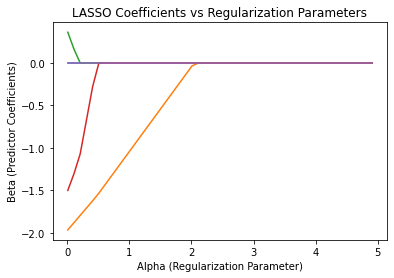

In [179]:
# Graph
coef = []
alphas = np.arange(0.01, 5, 0.10)
lasso = Lasso(max_iter=10000)

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef.append(lasso.coef_)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas, coef)
ax.set_xlabel("Alpha (Regularization Parameter)")
ax.set_ylabel("Beta (Predictor Coefficients)")
ax.set_title("LASSO Coefficients vs Regularization Parameters")
# ax.axis("tight")

**Explanation Here**

In [180]:
# K Fold Cross Validation
model = LassoCV(cv=10, random_state=0, max_iter=10000)
model.fit(X_train, y_train)
model.alpha_

0.0020443349928352295

**Explanation Here**

In [181]:
coefs = np.array(model.coef_)
coefs

array([ 0.00257216, -1.97398816,  0.37851828, -1.51704904,  0.        ])

### Final Model

$Y = -1.8002X_{age} + 0.9076X_{Male} - 1.0713X_{Female}$

**Explanation Here**